# Prepare Environment

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from tqdm import tqdm
import os
from os import listdir
import sys
import glob
from PIL import Image
import pickle
from pickle import dump, load
#from google.colab import drive
%matplotlib inline

# VGG-16
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

# Model Definition
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import ModelCheckpoint

# Evaluation
from nltk.translate.bleu_score import corpus_bleu

In [2]:
# Filenames
local_root='/'
local_dataset='Data/Flickr8k_Dataset/'
local_text='Data/Flickr8k_text'
local_features='Data/features.pkl'
local_descriptions='Data/descriptions.txt'
local_tokenizer='Data/tokenizer.pkl'
local_model='Data/model_19.h5'
local_samples='Sample Images/'

colab_root='/content/drive/My Drive/'
colab_dataset='/content/drive/My Drive/Flickr8k_Dataset'
colab_text='/content/drive/My Drive/Flickr8k_text'
colab_features='/content/drive/My Drive/Image Captioning/features.pkl'
colab_descriptions='/content/drive/My Drive/Image Captioning/descriptions.txt'
colab_tokenizer='/content/drive/My Drive/Image Captioning/tokenizer.pkl'
colab_model='/content/drive/My Drive/Image Captioning/model_19.h5'
colab_samples='/content/drive/My Drive/Image Captioning/Sample Images/'

inColab= 'google.colab' in str(get_ipython())

trainImageExtractor=False
trainImageCaptiongenerator=False
evaluateBLEUScore=False

In [3]:
tf.test.gpu_device_name()

''

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2480481589228550200,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5266991984872201955
 physical_device_desc: "device: XLA_CPU device"]

In [5]:
if inColab:
    drive.mount('/content/drive')

# Photo Features

In [6]:
if trainImageExtractor:
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print(model.summary())

In [7]:
def extract_features(directory):
    features = dict()
    for name in tqdm(listdir(directory)):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
        #print('>%s' % name)
    return features

In [8]:
if trainImageExtractor:
    directory = colab_dataset if inColab else local_dataset
    features = extract_features(directory)
    print('Extracted Features: %d' % len(features))
    #dump(features, open('features.pkl', 'wb'))

In [9]:
directory = colab_dataset if inColab else local_dataset
features = load(open(colab_features if inColab else local_features, 'rb'))
print('Extracted Features: %d' % len(features))

Extracted Features: 8096


# Text Preparation

In [10]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

filename = colab_text if inColab else local_text +'/Flickr8k.token.txt'
doc = load_doc(filename)

In [11]:
doc[:250]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n100026'

In [12]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [13]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)
            
clean_descriptions(descriptions)

In [15]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [16]:
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

vocabulary = to_vocabulary(descriptions)
vocabulary_list = list(vocabulary)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


In [17]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
#save_descriptions(descriptions, 'descriptions.txt')

In [18]:
filename = colab_text if inColab else local_text +'/Flickr8k.token.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
print('Sample Descriptions List:')
print('ID: 1000268201_693b08cb0e')
print('Descriptions:\n',descriptions['1000268201_693b08cb0e'])
clean_descriptions(descriptions)
print('Clean Descriptions:\n',descriptions['1000268201_693b08cb0e'])
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
#save_descriptions(descriptions, '/content/drive/My Drive/Image Captioning/descriptions.txt')

Loaded: 8092 
Sample Descriptions List:
ID: 1000268201_693b08cb0e
Descriptions:
 ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
Clean Descriptions:
 ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']
Vocabulary Size: 8763


# Training

In [19]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [20]:
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

In [21]:
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features

In [22]:
filename = colab_text if inColab else local_text +'/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions(colab_descriptions if inColab else local_descriptions, train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features(colab_features if inColab else local_features, train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [23]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
 
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


In [24]:
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [25]:
def maxlength(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [26]:
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    print(model.summary())
    #plot_model(model, to_file='/tmp/model.png', show_shapes=True)
    return model

In [27]:
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    while 1:
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq], out_word

In [28]:
filename = colab_text if inColab else local_text + '/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions(colab_descriptions if inColab else local_descriptions, train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features(colab_features if inColab else local_features, train)
print('Photos: train=%d' % len(train_features))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = maxlength(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [29]:
generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(47, 4096)
(47, 34)
(47, 7579)


In [30]:
if trainImageCaptiongenerator:
    model = define_model(vocab_size, max_length)

In [31]:
if trainImageCaptiongenerator:
    epochs = 20
    steps = len(train_descriptions)
    for i in range(epochs):
        generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save('/tmp/model_' + str(i) + '.h5')

In [32]:
model = tf.keras.models.load_model(colab_model if inColab else local_model)

# Evaluation

In [33]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [34]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [35]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in tqdm(descriptions.items()):
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [36]:
filename = colab_text if inColab else local_text +'/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions(colab_descriptions if inColab else local_descriptions , train)
print('Descriptions: train=%d' % len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = maxlength(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34


In [37]:
filename = colab_text if inColab else local_text+'/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
test_descriptions = load_clean_descriptions(colab_descriptions if inColab else local_descriptions, test)
print('Descriptions: test=%d' % len(test_descriptions))
test_features = load_photo_features(colab_features if inColab else local_features, test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [38]:
if evaluateBLEUScore:
    evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

In [39]:
#dump(tokenizer, open('/content/drive/My Drive/Image Captioning/tokenizer.pkl', 'wb'))

# Generate New Captions

In [40]:
tokenizer = load(open(colab_tokenizer if inColab else local_tokenizer, 'rb'))
max_length = 34

In [41]:
model = tf.keras.models.load_model(colab_model if inColab else local_model)

In [42]:
def extract_features(filename):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

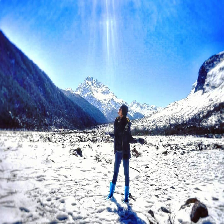

man in red shirt is standing on rock


In [46]:
for i in range(7,8):
    img_path=colab_samples if inColab else local_samples+'Sample_'+str(i)+'.jpg'
    img=load_img(img_path, target_size=(224, 224))
    photo = extract_features(img_path)
    description = generate_desc(model, tokenizer, photo, max_length)
    display(img)
    print(' '.join(description.split()[1:-1]))